# Target Engineering - Directional

Directional targets are essential in quantitative trading for building models that predict the **market direction** (e.g., bullish vs. bearish scenarios). By transforming raw price data into **binary or multi-class labels**, directional targets help structure classification problems for systematic trading strategies. In this notebook, we will generate and analyze **directional targets** using the `quantreo` package to improve signal clarity and model decision-making under varying market regimes.

In [4]:
# Import the Target Engineering Package from Quantreo
import quantreo.target_engineering as te

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv
df = load_generated_ohlcv()
df = df.loc["2016"]

# Show the data
df

,open,high,low,close,volume
time,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605
...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665


<br>

## **Future Returns Sign**

The `future_returns_sign` function generates a **binary directional target** based on future returns.

- It computes the return between the current price and the price `window_size` steps ahead.
- Then it assigns a **positive label** (default `1`) if the return is strictly positive, otherwise a **negative label** (default `0`).

This target is ideal for **trend-following models** or binary classification.


In [5]:
df["label"] = te.directional.future_returns_sign(df, close_col='close', window_size=10, log_return=True)
df["label"]

time
2016-01-04 00:00:00    1
2016-01-04 04:00:00    1
2016-01-04 08:00:00    1
2016-01-04 12:00:00    1
2016-01-04 16:00:00    1
                      ..
2016-12-30 04:00:00    0
2016-12-30 08:00:00    0
2016-12-30 12:00:00    0
2016-12-30 16:00:00    0
2016-12-30 20:00:00    0
Name: label, Length: 1548, dtype: int64

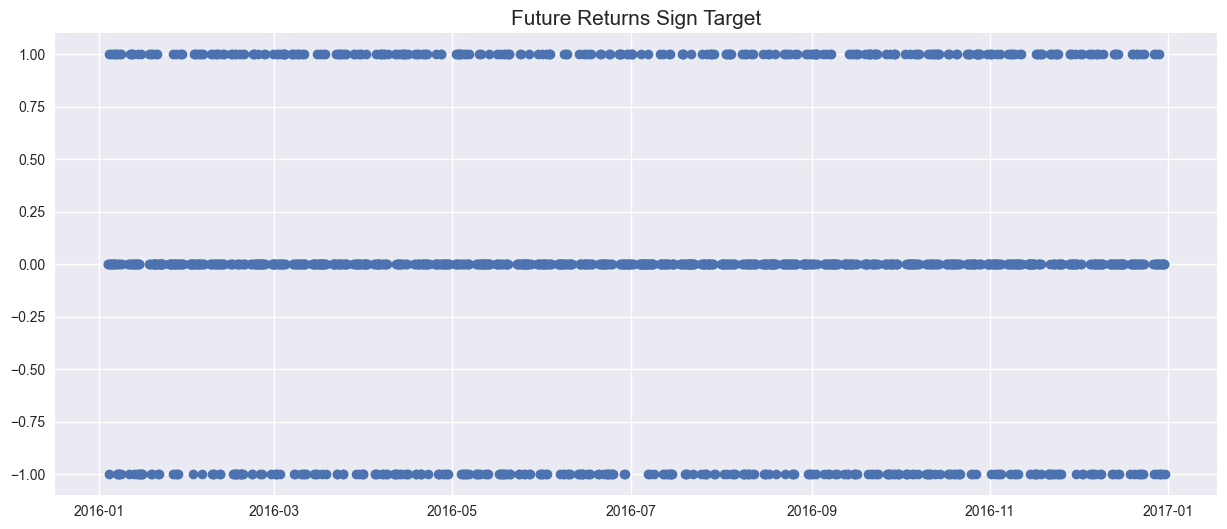

In [22]:
plt.figure(figsize=(15,6))
plt.plot(df["label"], "o")
plt.title("Future Returns Sign Target", size=15)
plt.show()

<br>

## **Quantile Label**

The `quantile_label` function creates a **multi-class target** based on quantiles.

- Assigns a **positive label** to values above a certain quantile (e.g., the 67th percentile).
- Assigns a **negative label** to values below a lower quantile (e.g., the 33rd percentile).
- Assigns a **neutral label** for values in between.

**WARNING**: When using quantile-based targets, always compute the **quantile thresholds on the training set only**, and apply them to the test set to generate labels. Computing quantiles on the full dataset would introduce a **look-ahead bias**, leaking future information into your model.

In [12]:
df["pct_change"] = df["close"].pct_change(1)

In [13]:
# Basic call
df["label"] = te.directional.quantile_label(df, col='pct_change', upper_quantile_level=0.67, lower_quantile_level=0.33)
df["label"]

time
2016-01-04 00:00:00    0
2016-01-04 04:00:00   -1
2016-01-04 08:00:00    1
2016-01-04 12:00:00   -1
2016-01-04 16:00:00    1
                      ..
2016-12-30 04:00:00   -1
2016-12-30 08:00:00    0
2016-12-30 12:00:00   -1
2016-12-30 16:00:00   -1
2016-12-30 20:00:00   -1
Name: label, Length: 1548, dtype: int64

In [18]:
# Train set call
df["label"], q_high, q_low = te.directional.quantile_label(df, col='pct_change', upper_quantile_level=0.80, lower_quantile_level=0.20, return_thresholds=True)
print(q_high, q_low)
df["label"]

0.0011974472411912186 -0.0012601039843373794


time
2016-01-04 00:00:00    0
2016-01-04 04:00:00    0
2016-01-04 08:00:00    1
2016-01-04 12:00:00   -1
2016-01-04 16:00:00    0
                      ..
2016-12-30 04:00:00    0
2016-12-30 08:00:00    0
2016-12-30 12:00:00    0
2016-12-30 16:00:00    0
2016-12-30 20:00:00   -1
Name: label, Length: 1548, dtype: int64

In [19]:
# Test set call
df["label"] = te.directional.quantile_label(df, col='pct_change', q_high=q_high, q_low=q_low)
df["label"]

time
2016-01-04 00:00:00    0
2016-01-04 04:00:00    0
2016-01-04 08:00:00    1
2016-01-04 12:00:00   -1
2016-01-04 16:00:00    0
                      ..
2016-12-30 04:00:00    0
2016-12-30 08:00:00    0
2016-12-30 12:00:00    0
2016-12-30 16:00:00    0
2016-12-30 20:00:00   -1
Name: label, Length: 1548, dtype: int64

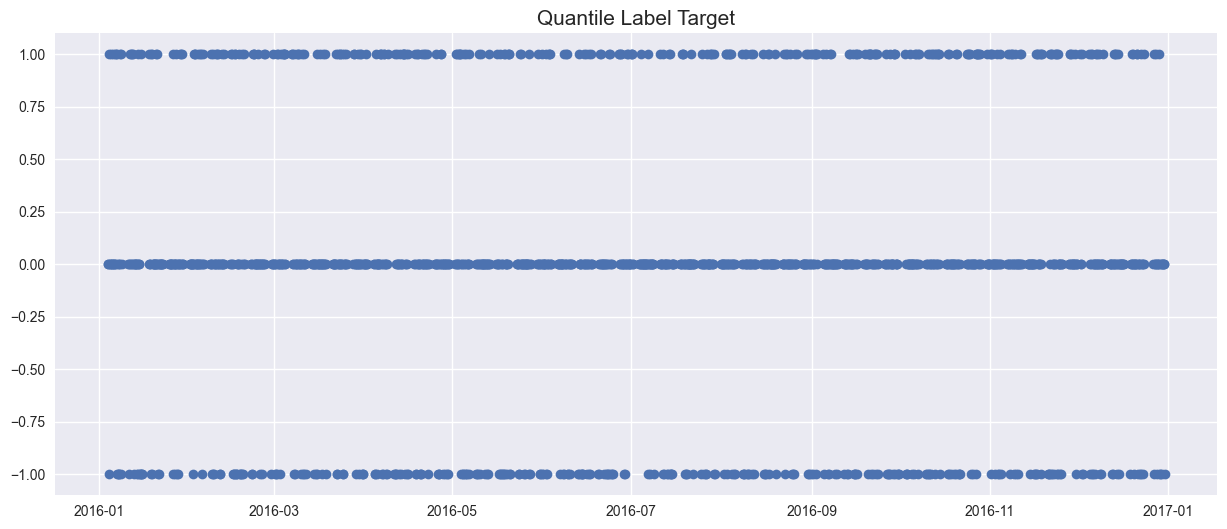

In [21]:
plt.figure(figsize=(15,6))
plt.plot(df["label"], "o")
plt.title("Quantile Label Target", size=15)
plt.show()